# **Lab 6 Transfer Learning & Hyperparameter Tuning**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.

In [16]:
### START CODE HERE ###
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, resize=128, crop_size=128, gauss_noise=False, gauss_blur=False, p=0.5):
        self.image_paths = image_paths
        self.resize = resize
        self.crop_size = crop_size
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.p = p

    def __len__(self):
        return len(self.image_paths)

    def clip_to_uint8(self, image):
        """Clips image values to the range of 0-255 (uint8 format)"""
        return np.clip(image * 255.0, 0, 255).astype(np.uint8)  # Rescale and clip

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize and crop
        image = cv2.resize(image, (self.resize, self.resize))
        
        h, w, _ = image.shape
        start_x = (w - self.crop_size) // 2
        start_y = (h - self.crop_size) // 2
        image = image[start_y:start_y+self.crop_size, start_x:start_x+self.crop_size]

        # Ground truth
        gt_image = image.copy()

        # Augmentations
        if random.random() < self.p:
            if self.gauss_noise:
                # Add Gaussian noise
                noise_mean = random.uniform(-50, 50)
                var = 0.01
                noise = random_noise(image.astype(np.float32) / 255.0, mode='gaussian', var=var)  # var controls noise level
                image = image.astype(np.float32) / 255.0 + noise
                image = np.clip(image * 255.0, 0, 255).astype(np.uint8)  # Clip after adding noise
                #print(f"noise_mean: {noise_mean:.3f}", end=",\t")

            if self.gauss_blur:
                kernel_size = random.randint(3, 11)
                kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1
                sigmaX = kernel_size / 3
                image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigmaX)
                #print("kernel_size", kernel_size)

        # Preprocess for PyTorch
        image = image.astype(np.float32) / 255.0
        gt_image = gt_image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        gt_image = torch.from_numpy(gt_image).permute(2, 0, 1)

        return image, gt_image
### END CODE HERE ###

In [17]:
### START CODE HERE ###
def convert_tensor_to_image(tensor, normalize=True):
    """
    Convert a tensor to a numpy image array.
    
    Parameters:
    - tensor (torch.Tensor): Input tensor of shape (C, H, W) or (N, C, H, W).
    - normalize (bool): Whether to normalize the image data to the range [0, 1].
    
    Returns:
    - np.ndarray: Image array with shape (H, W, C) for a single image or (N, H, W, C) for a batch.
    """
    if tensor.ndimension() == 4:
        # Batch of images
        tensor = tensor[0]  # Take the first image in the batch
        
    # Convert to numpy
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    
    # Normalize to [0, 1] if needed
    if normalize:
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
    
    return image

def imshow_grid(images, normalize=True, cmap=None):
    """
    Display a grid of images.
    
    Parameters:
    - images (list of torch.Tensor or np.ndarray): List of images to display.
    - normalize (bool): Whether to normalize images before displaying.
    - cmap (str or None): Colormap for grayscale images (e.g., 'gray'). None for color images.
    """
    num_images = len(images)
    sqrt_n = int(np.ceil(np.sqrt(num_images)))
    fig, axes = plt.subplots(sqrt_n, sqrt_n, figsize=(sqrt_n*2, sqrt_n*2))
    axes = axes.flatten()
    
    for i in range(num_images):
        # Convert tensor to image
        if isinstance(images[i], torch.Tensor):
            image = convert_tensor_to_image(images[i], normalize)
        else:
            image = images[i]

        # Determine if the image is grayscale or color
        if cmap:  # Apply colormap if specified
            if image.ndim == 3 and image.shape[2] == 3:
                # Convert color image to grayscale using average method
                image_gray = np.mean(image, axis=2)
                axes[i].imshow(image_gray, cmap=cmap)
            else:
                axes[i].imshow(image, cmap=cmap)
        else:
            axes[i].imshow(image)
            
        axes[i].axis('off')
    
    # Hide any remaining axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
### END CODE HERE ###

In [18]:
### START CODE HERE ###
data_dir = "../Lab5_CNN/images/img_align_celeba/"
image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
print("Size:",len(image_paths))

dataset = CustomImageDataset(image_paths, gauss_noise=True, gauss_blur=True)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size)
### END CODE HERE ###

Size: 13882


Noisy blury images


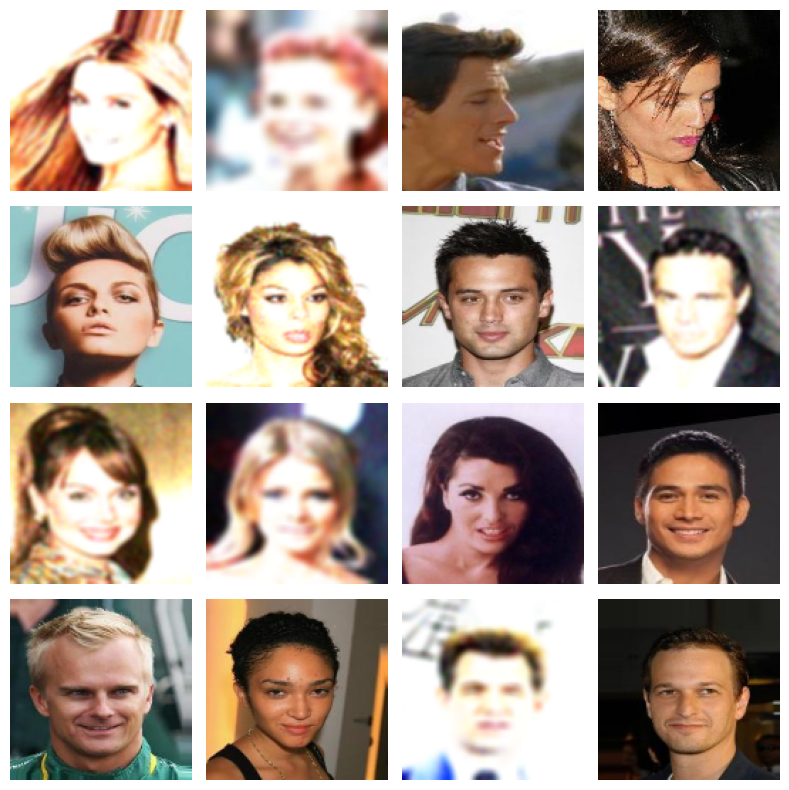

Ground Truth images


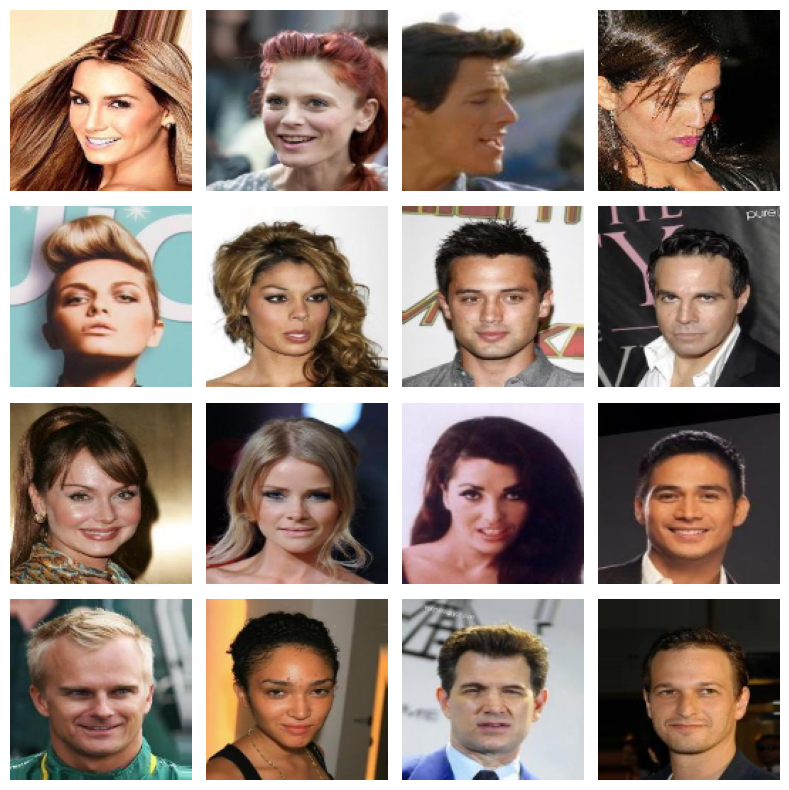

In [19]:
### START CODE HERE ###
batch, gt_img = next(iter(dataloader))

# Display the first image and its ground truth
print("Noisy blury images")
imshow_grid(batch[:batch_size])
print("Ground Truth images")
imshow_grid(gt_img[:batch_size])
### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model with a customizable number of downsampling and upsampling blocks by passing a list of channel numbers for each layer based on the provided code below. However, please maintain the concept of 'Autoencoder'.

In [20]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, channels=[64, 128, 256], input_channels=3, output_channels=3):
        super(Autoencoder, self).__init__()

        # Encoder
        self.conv_in = nn.Conv2d(input_channels, channels[0], kernel_size=3, stride=1, padding=1)
        self.downsampling_blocks = nn.ModuleList()
        in_channels = channels[0]
        for out_channels in channels:
            self.downsampling_blocks.append(DownSamplingBlock(in_channels, out_channels))
            in_channels = out_channels
        
        # Decoder
        self.upsampling_blocks = nn.ModuleList()
        reversed_channels = list(reversed(channels))
        for i in range(len(reversed_channels) - 1):
            self.upsampling_blocks.append(UpSamplingBlock(reversed_channels[i], reversed_channels[i + 1]))
        
        # Final Convolution to get the original image size
        self.conv_out = nn.Conv2d(reversed_channels[-1], output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = self.conv_in(x)  # Shape: [batch_size, channels[0], H, W]

        for block in self.downsampling_blocks:
            x = block(x)  # Shape transitions according to the downsampling blocks

        # Decoder
        for block in self.upsampling_blocks:
            x = block(x)  # Shape transitions according to the upsampling blocks

        # Resize to match the input size (128x128) if necessary
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=True)  # Shape: [batch_size, channels[0], 128, 128]

        # Final Convolution to get the original image size
        x = self.conv_out(x)  # Shape: [batch_size, output_channels, 128, 128]

        return x
### END CODE HERE ###
        

In [21]:
model = Autoencoder()
print(model)

Autoencoder(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsampling_blocks): ModuleList(
    (0): DownSamplingBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownSamplingBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownSamplingBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool): 

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [22]:
### START CODE HERE ###
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print(f"🤖 Training on {device}")
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch', leave=False)
        for images, gt in train_bar:
            images, gt = images.to(device), gt.to(device)
            
            opt.zero_grad()
            output = model(images)
            
            if output.shape != gt.shape:
                raise ValueError(f"Output shape {output.shape} does not match ground truth shape {gt.shape}")

            loss = loss_fn(output, gt)
            loss.backward()
            opt.step()
            
            train_loss += loss.item()
            avg_train_loss = train_loss / (train_bar.n + 1)
            train_bar.set_postfix(loss=f"{avg_train_loss:.4f}")

        avg_train_loss = train_loss / len(train_loader)
        print(f"\nEpoch [{epoch+1}/{epochs}] - Average Training Loss: {avg_train_loss:.4f}")
        
        model.eval()
        test_loss = 0.0
        psnr_values = []
        ssim_values = []
        test_bar = tqdm(test_loader, desc=f'📄 Testing Epoch [{epoch+1}/{epochs}]', unit='batch', leave=False)
        with torch.no_grad():
            for images, gt in test_bar:
                images, gt = images.to(device), gt.to(device)
                output = model(images)
                
                if output.shape != gt.shape:
                    raise ValueError(f"Output shape {output.shape} does not match ground truth shape {gt.shape}")
                
                loss = loss_fn(output, gt)
                test_loss += loss.item()
                
                for i in range(images.size(0)):
                    gt_image = gt[i].cpu().numpy().transpose(1, 2, 0)
                    output_image = output[i].cpu().numpy().transpose(1, 2, 0)

                    data_range=255.0 # Assuming images are normalized in the range [0, 255]
                    
                    psnr_value = psnr(gt_image, output_image, data_range=data_range)
                    ssim_value = ssim(gt_image, output_image, multichannel=True, win_size=3, data_range=data_range)
                    
                    psnr_values.append(psnr_value)
                    ssim_values.append(ssim_value)
                
                avg_test_loss = test_loss / (test_bar.n + 1)
                test_bar.set_postfix(loss=f"{avg_test_loss:.4f}", psnr=f"{np.mean(psnr_values):.1f}", ssim=f"{np.mean(ssim_values):.3f}")

        avg_test_loss = test_loss / len(test_loader)
        avg_psnr = np.mean(psnr_values)
        avg_ssim = np.mean(ssim_values)
        
        print(f"\nSummary :")
        print(f"\tTrain\tavg_loss: {avg_train_loss:.6f}")
        print(f"\tTest\tavg_loss: {avg_test_loss:.6f}")
        print(f"\t\tPSNR : {avg_psnr:.6f}")
        print(f"\t\tSSIM : {avg_ssim:.6f}")

        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model saved to {checkpoint_path}")
### END CODE HERE ###

Let's train your model with 2 epochs to verify that your train() function works properly. After that, we'll move on to the Hyperparameter Grid Search in the next part.

In [23]:
# ## START CODE HERE ###
# data_dir = "../Lab5_CNN/images/img_align_celeba/"

# files = os.listdir(data_dir)
# files = [os.path.join(data_dir, file) for file in files]

# # Split the dataset into training and testing sets
# train_files, test_files = train_test_split(files, test_size=0.3, shuffle=True, random_state=2024)

# train_dataset = CustomImageDataset(train_files, gauss_noise=True, gauss_blur=True)
# test_dataset = CustomImageDataset(test_files, gauss_noise=True, gauss_blur=True)
# trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# ## END CODE HERE ###

In [24]:
data_dir = "../Lab5_CNN/images/img_align_celeba/"

# List all image files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]

# Define the size of the subsets
train_size = 15  # Number of images for training
test_size = 20     # Number of images for testing

# Sample a small subset of files
sampled_files = np.random.choice(files, size=train_size + test_size, replace=False)

# Split the sampled files into training and testing sets
train_files, test_files = train_test_split(sampled_files, test_size=test_size, random_state=42)

# Create dataset objects with the option for augmentations like Gaussian noise and blur
train_dataset = CustomImageDataset(train_files, gauss_noise=True, gauss_blur=True)
test_dataset = CustomImageDataset(test_files, gauss_noise=True, gauss_blur=True)



# Create DataLoaders for both training and testing datasets
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Print the sizes of the datasets
print(f"Number of training files: {len(train_files)}")
print(f"Number of test files: {len(test_files)}")

Number of training files: 15
Number of test files: 20


In [25]:
### START CODE HERE ###
model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Optionally specify a path to save the model
checkpoint_path = "autoencoder_checkpoint.pth"

# Train the model
train(model, opt, loss_fn, trainloader, testloader, epochs=1, checkpoint_path=checkpoint_path, device='cpu')
### END CODE HERE ###

🤖 Training on cpu



Epoch [1/1] - Average Training Loss: 0.3253



Summary :
	Train	avg_loss: 0.325252
	Test	avg_loss: 0.255647
		PSNR : 54.537338
		SSIM : 0.965941
Model saved to autoencoder_checkpoint.pth


---

## **Hyperparameter Grid Search with Raytune**

*If you have access to APEX, I would recommend converting this part into a Python file and submitting the job to run on APEX using SBATCH. This process may take a considerable amount of time.*

You can import additional Ray Tune tools as you want, such as schedulers, search algorithms, etc. Further information on the usage of Ray Tune can be found [here](https://docs.ray.io/en/latest/tune/index.html).

In [26]:
import ray
from ray import tune
from ray.air import session
from ray.train import RunConfig

ray.shutdown()

Complete the `train_raytune()` function below, following the [quick start guide](https://docs.ray.io/en/latest/tune/index.html). This function will be passed to the `tune.Tuner`.

In [27]:
### START CODE HERE ###
def train_raytune(config):
    torch.manual_seed(4912)
    
    # Prepare Data
    # Create Dataloader (Assuming train_dataset and test_dataset are defined elsewhere)
    trainloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
    
    
    device = "cuda" if torch.cuda.is_available() else "cpu" 
    # Initialize Autoencoder with dynamic channels
    model = Autoencoder(channels=config['architecture'], input_channels=config['input_channels'], output_channels=config['output_channels'])
    model = model.to(device) 
    loss_fn = nn.MSELoss()
    
    # Define optimizer based on config
    if config['optimizer'] == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        opt = torch.optim.SGD (model.parameters(), lr=config['lr'])
        
    for epoch in range(config['num_epochs']):
        model.train() 
        avg_train_loss= 0
        avg_test_loss = 0
        for images, gt in trainloader: 
            # Train Model
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, gt)
            loss.backward()
            opt.step()
            avg_train_loss += loss.item()
        avg_train_loss /= len(trainloader)
        total_psnr = 0
        total_ssim = 0 
        model.eval()
        for images, gt in testloader: 
            # Evaluate model
            with torch.no_grad():
                outputs = model(images)
                loss = loss_fn(outputs, gt)
            avg_test_loss += loss.item()
            total_psnr += psnr(outputs, gt)
            total_ssim += ssim(outputs, gt)
            
        avg_psnr = total_psnr / len(testloader) 
        avg_ssim = total_ssim / len(testloader) 
        avg_test_loss /= len(testloader)
        
        # Report metrics to Raytune
        session.report({
            "train_loss": avg_train_loss,
            "val_loss": avg_test_loss,
            "val_psnr": avg_psnr,
            "val_ssim": avg_ssim,
        })
        
### END CODE HERE ###

Initialize Ray, define the search space, and resources.

Resource : 
- [A Guide To Parallelism and Resources for Ray Tune](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html#:~:text=A%20Guide%20To%20Parallelism%20and%20Resources%20for%20Ray%20Tune) 
- [Working with Tune Search Spaces](https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial:~:text=Working%20with%20Tune%20Search%20Spaces)
- [How to configure logging in Tune?](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html) 
- [Tune Trial Schedulers (`tune.schedulers`)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-pbt:~:text=Tune%20Trial...-,Tune%20Trial%20Schedulers%20(tune.schedulers),-%23)

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [28]:
### START CODE HERE ###
# Convert relative path to absolute path
relative_path = '../Lab6_Hyperparameter-Tuning/ray_results/'
absolute_path = os.path.abspath(relative_path)
print(f"Absolute path: {absolute_path}")

# Create the directory if it doesn't exist
os.makedirs(absolute_path, exist_ok=True)

# Ensure any existing Ray sessions are shut down
ray.shutdown()

ray.init(num_gpus=1, ignore_reinit_error=True)

# Define the grid search space
config = {
    'architecture': tune.grid_search([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512]
    ]),
    'lr': tune.grid_search([1e-3, 8e-4, 1e-4, 1e-2]),
    'batch_size': tune.grid_search([16, 32]),
    'num_epochs': tune.grid_search([10, 50, 100]),
    'optimizer': tune.grid_search(['Adam', 'SGD']),
    'input_channels': 3,
    'output_channels': 3
}

tuner = tune.Tuner(
    train_raytune,
    run_config=RunConfig(
        storage_path=absolute_path,  # Directory to store logs and results
        log_to_file=True     # Enable logging to file
    ),
    tune_config=tune.TuneConfig(
        metric="val_psnr",  # Metric to optimize
        mode="max",         # Mode for optimization (maximization)
        num_samples=1       # Number of samples to try (Grid search will cover all)
    ),
    param_space=config
)
result = tuner.fit()

### END CODE HERE ###

2024-09-16 22:58:17,884	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\Acer\AppData\Local\Temp\ray\session_2024-09-16_22-58-05_132372_17252\artifacts\2024-09-16_22-58-16\train_raytune_2024-09-16_22-58-16\driver_artifacts\train_raytune_7c828_00000_0_architecture=32_64_128,batch_size=16,lr=0.0010,num_epochs=10,optimizer=Adam_2024-09-16_22-58-17
2024-09-16 22:58:17,942	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\Acer\AppData\Local\Temp\ray\session_2024-09-16_22-58-05_132372_17252\artifacts\2024-09-16_22-58-16\train_raytune_2024-09-16_22-58-16\driver_artifacts\train_raytune_7c828_00000_0_architecture=32_64_128,batch_size=16,lr=0.0010,num_epochs=10,optimizer=Adam_2024-09-16_22-58-17
2024-09-16 22:58:18,055	WARNING trial.py:647 -- The path to the trial log 

Restore the result from path of ray resule directory

In [ ]:
### START CODE HERE ###
path = ""
restored_tuner = tune.Tuner.restore(path, trainable='train_raytune')
### END CODE HERE ###

FileNotFoundError: The directory ray_results/autoencoder_tuning is empty. Ensure that tuning has been run and results are saved.

Get the report from Grid Search to CSV file.

In [ ]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()

# Save the DataFrame to a CSV file
csv_path = "ray_results_CV/tuning_grid_search_results.csv"  # Define your desired CSV file path
df.to_csv(csv_path, index=False)

---

Train the Autoencoder models using the best hyperparameter set obtained from the grid search.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers. Then, save it as an image.


In [ ]:
import math
class FeatureMapVisualizer:
    def __init__(self, model, layers, save_dir):
        """
        Parameters:
        - model: The PyTorch model
        - layers: A string or list of strings specifying the layer names to visualize
        - save_dir: Directory to save the output feature map images
        """
        self.model = model
        self.layers = layers if isinstance(layers, list) else [layers]
        self.activations = {}
        self.save_dir = save_dir

        os.makedirs(self.save_dir, exist_ok=True)

        self._register_hooks()

    def _register_hooks(self):
        for name, layer in self.model.named_modules():
            if name in self.layers:
                layer.register_forward_hook(self._hook_fn(name))

    def _hook_fn(self, layer_name):
        def hook(module, input, output):
            print(f'Hooking layer: {layer_name}')
            self.activations[layer_name] = output.detach()
        return hook

    def visualize(self, input_paths):
        """
        Pass an input tensor through the model and visualize the activations.
        
        Parameters:
        - input_paths: List of image paths to pass through the model
        """
        
        for img_path in input_paths:
            self.model(img_path)

            for layer_name, activation in self.activations.items():
                print(f'Visualizing and saving layer: {layer_name}')
                self._save_feature_maps(activation, layer_name)

    def _save_feature_maps(self, activation, layer_name):
        ### START CODE HERE ###
        num_channels = activation.shape[1]
        






        
        ### END CODE HERE ###

In [ ]:
### START CODE HERE ###

visualizer = FeatureMapVisualizer(None)
visualizer.visualize([None])


### END CODE HERE ###

---
## **Hyperparameter Random Search with Raytune**

**Search Space:**

- **`architecture`:**  
    Define the feature map dimensions for convolutional layers:  
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with additional depth, starting from 64 and ending at 512.
  
- **`learning rates (lr)`**:  
    A continuous range of learning rates sampled uniformly between `1e-4` and `1e-2`. This allows exploration of different learning rates from conservative (`1e-4`) to more aggressive (`1e-2`) values.

- **`batch size`**:  
    Randomly sample an integer batch size between 16 and 32 (inclusive). This allows testing of smaller batch sizes, which can affect gradient estimation and memory usage.

- **`number of epochs`**:  
    Randomly sample an integer number of epochs between 10 and 100. This allows the model to train for short (e.g., 10 epochs) or extended periods (up to 100 epochs), giving insight into model performance over different training durations.

- **`optimizers (opts)`**:  
    Randomly select between two optimizers:  
    - `"Adam"`: An adaptive learning rate optimizer that generally performs well across various tasks.  
    - `"SGD"`: Stochastic Gradient Descent with momentum, commonly used for large-scale tasks, requiring careful tuning of the learning rate.

***NOTE*** Random search with 80 samples.

In [ ]:
### START CODE HERE ###
ray.shutdown()
ray.init(num_gpus=1)

# Define the search space
config = {
    'architecture': tune.choice([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512]
    ]),
    'lr': tune.uniform(1e-4, 1e-2),
    'batch_size': tune.randint(16, 33),
    'num_epochs': tune.randint(10, 101),
    'optimizer': tune.choice(['Adam', 'SGD']),
}

# Set up the random search
tuner = tune.Tuner(
    train_raytune,
    tune_config=tune.TuneConfig(
        metric="val_psnr",
        mode="max",
        search_alg=tune.search.random.RandomSearch(),
        num_samples=80  # Number of random samples to evaluate
    ),
    param_space=config
)

# Run the search
results = tuner.fit()

### END CODE HERE ###

In [ ]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()
df.to_csv('', index=False)

# ray.shutdown()

---

Train the Autoencoder models using the best hyperparameter set obtained from the random search.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.

In [ ]:
### START CODE HERE ###

visualizer = FeatureMapVisualizer(None)
visualizer.visualize([None])


### END CODE HERE ###

---

# Questions

1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
2. What are the top 3 best parameters and their corresponding tuning results for the model?
3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.


